In [267]:
import gzip
import math
import numpy
import random
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
from gensim.models import Word2Vec
import dateutil
from scipy.sparse import lil_matrix # To build sparse feature matrices, if you like
import pandas as pd
from gensim.parsing.preprocessing import STOPWORDS

import html
import random
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [268]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

This takes a 1.5 mins to run

In [269]:
# allRatings = [l for l in parse("ratebeer.json.gz")]
rawRatings = [l for l in parse("sampled_ratebeer.json.gz")][0] # sampled has 300,000 reviews

# Sample and compress dataset (ALREADY RAN DONT RUN)

In [ ]:
# # Random sample the dataset because it's too big

# sampleSize = 300000
# sampledAllRatings = random.sample(ratings, sampleSize)

In [ ]:
# import json

# with open("sampled_ratebeer.json", "w") as f:
#     json.dump(sampledAllRatings, f)

In [ ]:
# import gzip
# import shutil

# # File paths
# input_file = 'sampled_ratebeer.json'      # Your existing JSON file
# output_file = 'sampled_ratebeer.json.gz'  # Desired compressed file

# # Compress the JSON file
# with open(input_file, 'rb') as f_in:
#     with gzip.open(output_file, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# print(f"Compressed {input_file} to {output_file}")


Compressed sampled_ratebeer.json to sampled_ratebeer.json.gz


# Clean data

Check missing labels (beer/style)

In [442]:
df = pd.DataFrame(rawRatings)

In [443]:
df.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,Dogfish Head Midas Touch Golden Elixir,7293,198,9,Traditional Ale,3/5,6/10,4/5,6/10,15/20,1172188800,chef201atc,Clear copper pour with a white bubbly head tha...
1,Lost Abbey Red Barn Ale,64608,7043,6.7,Saison,4/5,8/10,3/5,7/10,14/20,1318204800,jgb9348,Hazy blonde coloured body with a hay glow and ...
2,Grand River 1913 Traditional,125081,8650,4.5,Klsch,3/5,7/10,3/5,7/10,15/20,1277164800,JesseM,On tap at GRs 3rd Anniversary tasting. Taps a ...
3,Sterkens White Ale,4568,527,4.7,Belgian White (Witbier),3/5,6/10,3/5,6/10,12/20,1264204800,markas101,"33 cl bottle, Fargo, ND, USA. Pale yellow colo..."
4,Delafield Pewaukee Porter,19652,2877,5.5,Porter,3/5,5/10,3/5,5/10,9/20,1113696000,robertsreality,Dark Brown Coloring with Light Tan Head. Dust...


In [444]:
df.shape

(300000, 13)

In [445]:
df.dtypes

beer/name             object
beer/beerId           object
beer/brewerId         object
beer/ABV              object
beer/style            object
review/appearance     object
review/aroma          object
review/palate         object
review/taste          object
review/overall        object
review/time           object
review/profileName    object
review/text           object
dtype: object

In [447]:
df.isna().sum() / len(df)

beer/name             0.0
beer/beerId           0.0
beer/brewerId         0.0
beer/ABV              0.0
beer/style            0.0
review/appearance     0.0
review/aroma          0.0
review/palate         0.0
review/taste          0.0
review/overall        0.0
review/time           0.0
review/profileName    0.0
review/text           0.0
dtype: float64

In [462]:
# correcting data type
def ratingToInt(rating):
    if type(rating) == int:
        return rating
    
    top, bottom = rating.split('/')
    return int(top)

# Remove no ABV beers
cleanedDf = df[df['beer/ABV'] != '-']
cleanedDf.reset_index()
cleanedDf['beer/ABV'] = cleanedDf['beer/ABV'].apply(float)         

cleanedDf['review/appearance'] = cleanedDf['review/appearance'].apply(ratingToInt)
cleanedDf['review/aroma'] = cleanedDf['review/aroma'].apply(ratingToInt) 
cleanedDf['review/palate'] = cleanedDf['review/palate'].apply(ratingToInt) 
cleanedDf['review/taste'] = cleanedDf['review/taste'].apply(ratingToInt) 
cleanedDf['review/overall'] = cleanedDf['review/overall'].apply(ratingToInt)


# Removing escape sequences from labels
cleanedDf['beer/style'] = cleanedDf['beer/style'].apply(html.unescape)

C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\1452417266.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['beer/ABV'] = cleanedDf['beer/ABV'].apply(float)
C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\1452417266.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['review/appearance'] = cleanedDf['review/appearance'].apply(ratingToInt)
C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\1452417266.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

# EDA

In [463]:
# Distribution of ratings in dataset
def plotRatingDist(ratingKey):
    x = cleanedDf[ratingKey]
    minRating, maxRating = x.min(), x.max()
    bins = [i for i in range(minRating, maxRating + 1)]
    plt.hist(x, bins, rwidth=0.9)
    plt.title(f"Distribution of {ratingKey}")
    plt.xlabel(ratingKey)
    plt.ylabel("Proportion")

In [464]:
# How many styles of beers are there?
cleanedDf[['beer/style']].describe()

,beer/style
count,285700
unique,89
top,India Pale Ale (IPA)
freq,18043


,review/appearance
count,285700.0
mean,3.0
std,1.0
min,1.0
25%,3.0
50%,3.0
75%,4.0
max,5.0


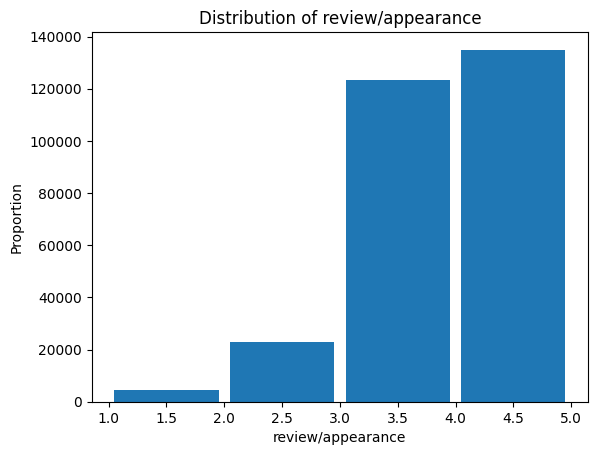

In [465]:
plotRatingDist('review/appearance')
cleanedDf[['review/appearance']].describe().round(0)

,review/aroma
count,285700.0
mean,6.0
std,2.0
min,1.0
25%,6.0
50%,7.0
75%,7.0
max,10.0


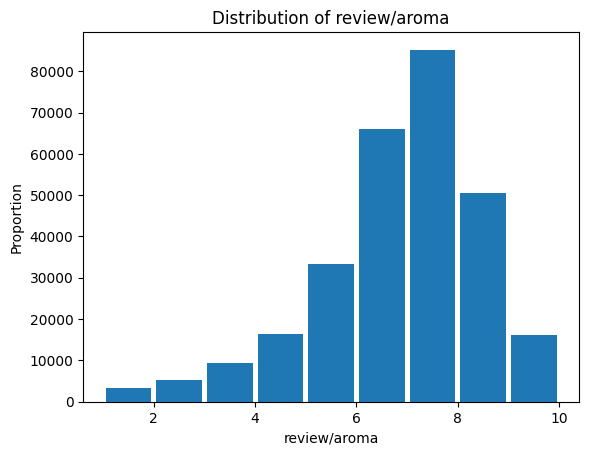

In [466]:
plotRatingDist('review/aroma')
cleanedDf[['review/aroma']].describe().round(0)

,review/palate
count,285700.0
mean,3.0
std,1.0
min,1.0
25%,3.0
50%,3.0
75%,4.0
max,5.0


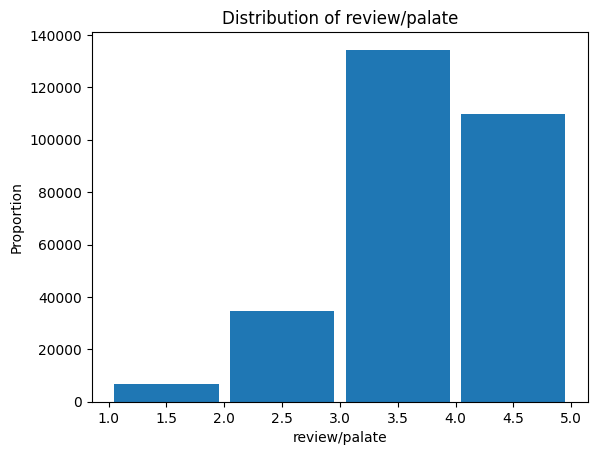

In [467]:
plotRatingDist('review/palate')
cleanedDf[['review/palate']].describe().round(0)

,review/taste
count,285700.0
mean,6.0
std,2.0
min,1.0
25%,6.0
50%,7.0
75%,8.0
max,10.0


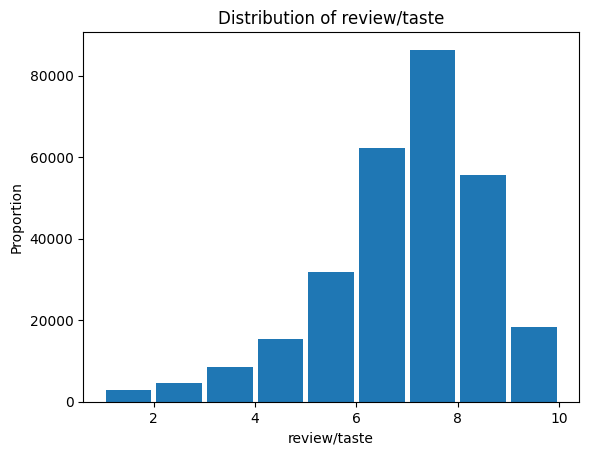

In [468]:
plotRatingDist('review/taste')
cleanedDf[['review/taste']].describe().round(0)

,review/overall
count,285700.0
mean,13.0
std,3.0
min,1.0
25%,12.0
50%,14.0
75%,15.0
max,20.0


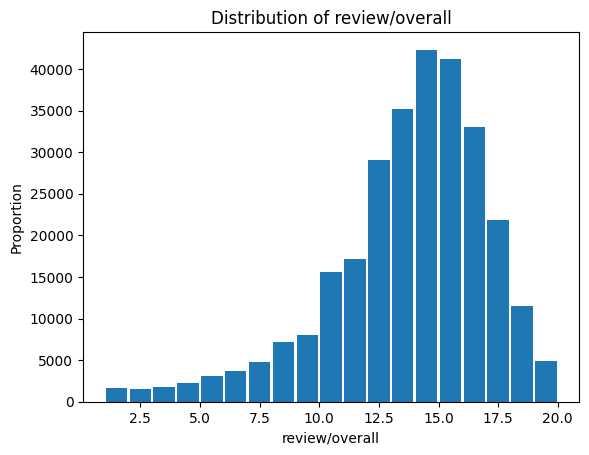

In [469]:
plotRatingDist('review/overall')
cleanedDf[['review/overall']].describe().round(0)

Review text length

In [470]:
cleanedDf['review/length'] = cleanedDf['review/text'].apply(len)

C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\342384755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['review/length'] = cleanedDf['review/text'].apply(len)


In [471]:
cleanedDf[['review/length']].describe().round(0)

,review/length
count,285700.0
mean,308.0
std,216.0
min,0.0
25%,176.0
50%,254.0
75%,374.0
max,8605.0


In [472]:
dfByRating = cleanedDf.groupby('review/overall')['review/length'].mean()

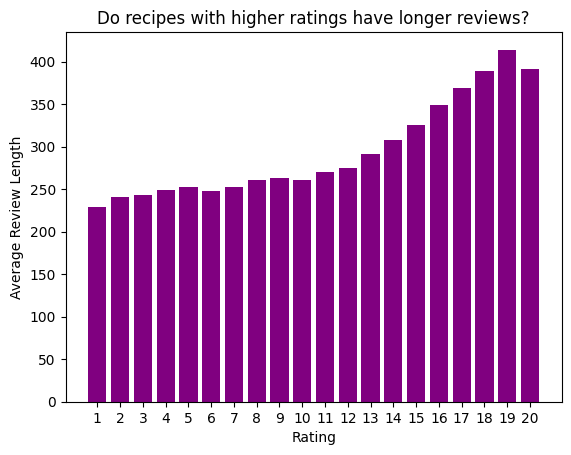

In [473]:
plt.bar(dfByRating.index, dfByRating.values, color = 'purple')
plt.xticks(dfByRating.index)
plt.title('Do recipes with higher ratings have longer reviews?')
plt.xlabel('Rating');
plt.ylabel('Average Review Length'); # no.

In [476]:
wordCount = defaultdict(int)
for i, rating in cleanedDf.iterrows():
    for w in rating['review/text'].split():
        wordCount[w] += 1

len(wordCount)

342767

### Per Flavor

The `beer_mapping.json` file contains mappings for beer types to flavor labels generated by ChatGPT to group beers into flavors. A beer can be in multiple flavors.

In [477]:
import json

with open('beer_mapping.json') as f:
    beerFlavorMapping = json.load(f)

def findFlavor(style: str) -> str:
    for flavor in beerFlavorMapping:
        if style in beerFlavorMapping[flavor]:
            return flavor

beerFlavorMapping.keys()

dict_keys(['malty', 'hoppy', 'crisp', 'roasty', 'fruity/spicy', 'sour', 'rich/hearty', 'smoky', 'specialty'])

In [480]:
cleanedDf['beer/flavor'] = cleanedDf['beer/style'].apply(findFlavor)

C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\1548089217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['beer/flavor'] = cleanedDf['beer/style'].apply(findFlavor)


Identify the counts for each style of beer

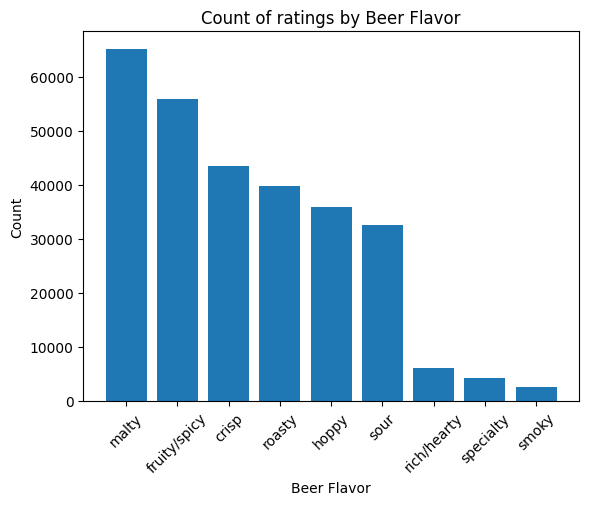

In [482]:
graph = plt.bar(cleanedDf['beer/flavor'].unique(), cleanedDf['beer/flavor'].value_counts())
plt.title('Count of ratings by Beer Flavor')
plt.xlabel('Beer Flavor')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [483]:
# Creates a df with no outliers
def removeOutlierFromDF(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    df['beer/ABV'] = df[feature].apply(float)

    # Clean the outliers out
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    noOutlierDF = df[(lower <= df[feature]) & (df[feature] <= upper)]
    return noOutlierDF

In [484]:
# Plots a bar graph grouped by beer flavor
def plotBarByFlavor(df: pd.DataFrame, y: str, title=''):
    sns.boxplot(data=df, x='beer/flavor', y=y)
    plt.title(title)
    plt.xlabel('Beer Flavor')
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.show()

ABV Distribution

C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\2268683075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beer/ABV'] = df[feature].apply(float)


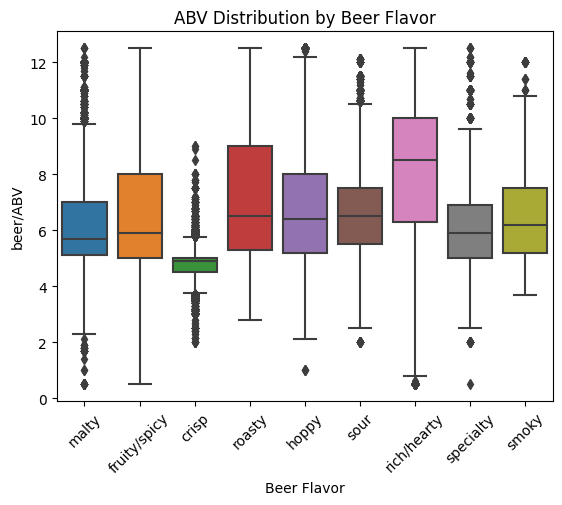

In [485]:
noOutlierABVDF = removeOutlierFromDF(cleanedDf, 'beer/ABV')
plotBarByFlavor(noOutlierABVDF, 'beer/ABV', 'ABV Distribution by Beer Flavor')

Review Text Length

In [486]:
cleanedDf['review/text length'] = cleanedDf['review/text'].apply(len)
noOutlierLengthDF = removeOutlierFromDF(cleanedDf, 'review/text length')

C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\1423692617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedDf['review/text length'] = cleanedDf['review/text'].apply(len)
C:\Users\edwar\AppData\Local\Temp\ipykernel_39488\2268683075.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['beer/ABV'] = df[feature].apply(float)


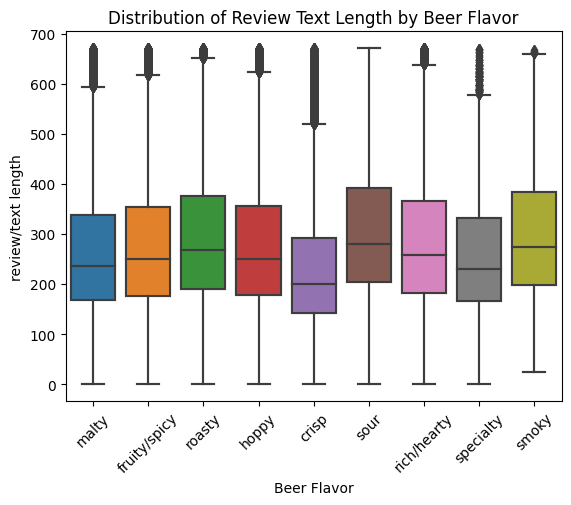

In [487]:
sns.boxplot(data=noOutlierLengthDF, x='beer/flavor', y='review/text length')
plotBarByFlavor(noOutlierLengthDF, 'review/text length', 'Distribution of Review Text Length by Beer Flavor')

# Get features
We get only the features we want to use ('beer/name', 'review/text')

In [199]:
# Only contains features we will use
filteredRatings = []

for rating in cleanedRatings:
    featureDict = {
        'beer/name': rating['beer/name'],
        'review/text': rating['review/text'],
        'beer/flavor': rating['beer/flavor']
    }
    
    filteredRatings.append(featureDict)

## Prepare the features
- Remove escape characters from `review/text`

In [200]:
# https://stackoverflow.com/questions/8115261/how-to-remove-all-the-escape-sequences-from-a-list-of-strings
escapeChars = ''.join([chr(char) for char in range(1, 32)])
translator = str.maketrans('', '', escapeChars)

# Remove escape characters from `review/text`
def removeEscapeChars(text: str) -> str:
    return text.translate(translator)

for rating in filteredRatings: 
    rating['beer/name'] = removeEscapeChars(rating['beer/name'])
    rating['review/text'] = removeEscapeChars(rating['review/text'])

# Split dataset

In [202]:
splitRatio = 0.95
splitIndex = int(len(filteredRatings) * splitRatio)
ratingsTrain = filteredRatings[:splitIndex]
ratingsTest = filteredRatings[splitIndex:]

len(ratingsTrain), len(ratingsTest)

(270954, 14261)

# TODO: Add the name to the features too

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
numbers = set([str(i) for i in range(10)])
for rating in filteredRatings:  
  r = ''.join([c for c in rating['review/text'].lower() if not c in punctuation and c not in numbers])
  for w in r.split():
    if w not in STOPWORDS:
      wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [237]:
words = [x[1] for x in counts[:1000]]

In [239]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

Unigram

In [ ]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation and c not in numbers])
    for w in r.split():
        if w in words and w not in STOPWORDS:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Takes a while to run

In [264]:
X = [feature(d) for d in ratingsTrain]
y = [d['beer/flavor'] for d in ratingsTrain]

In [265]:
mod = linear_model.LogisticRegression(C=1)
mod.fit(X, y)
theta = mod.coef_
predictions = mod.predict(X)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [266]:
correct = [p == rating['beer/flavor'] for p,rating in zip(predictions, ratingsTrain)]
sum(correct) / len(correct)

0.6332477099433852

In [257]:
Xtest = [feature(d) for d in ratingsTest]
ytest = [d['beer/flavor'] for d in ratingsTest]

In [258]:
testPredictions = mod.predict(Xtest)

In [260]:
correct = [p == rating['beer/flavor'] for p,rating in zip(testPredictions, ratingsTest)]
sum(correct) / len(correct)

0.6268845102026506

n-grams